In [28]:
#Setup
import numpy as np
from numpy.testing import assert_almost_equal
import scipy.integrate as integrate
from scipy.stats import norm
import matplotlib.pyplot as plt 


## Part 0 - Setup

In [29]:
### Constants
sigma1 = 0.11
sigma2 = 0.13
T = 1.7
mu = 0.13
r = 0.01
S0 = 149
time_break = 0.3
K = 188
KH = S0
n_sims = 5_000 #default value, overwritten later
n_steps = int(T * 365) #Assume time in years, this is daily time-steps

In [30]:
### Helper Functions

### Black-Scholes

def get_d1_and_d2(S, t, K, T, r, sigma):
    tau = T - t
    d1 = 1/(sigma * np.sqrt(tau)) * (np.log(S/K) + (r + sigma ** 2 / 2) * tau)    
    d2 = d1 - sigma * np.sqrt(tau)
    return d1, d2

def black_scholes_call_price(S, t, K, T, r,sigma):
    d1, d2 = get_d1_and_d2(S, t, K, T, r, sigma)
    return S * norm.cdf(d1) - K * np.exp(-r * (T- t)) * norm.cdf(d2)

def black_scholes_put_price(S,t, K,T,r,sigma):
    d1, d2 = get_d1_and_d2(S, t, K, T, r, sigma)
    return  K * np.exp(-r * (T - t)) * norm.cdf( -d2) - S * norm.cdf(-d1) 

def black_scholes_call_delta(S, t, K, T, r,sigma):
    d1, d2 = get_d1_and_d2(S, t, K, T, r, sigma)
    return norm.cdf(d1)

def black_scholes_put_delta(S, t, K, T, r,sigma):
    d1, d2 = get_d1_and_d2(S, t, K, T, r, sigma)
    return -1 * norm.cdf(-1 * d1)

def black_scholes_gamma(S, t, K, T, r,sigma):
    #same for a call and put
    d1, d2 = get_d1_and_d2(S, t, K, T, r, sigma)
    return norm.pdf(d1)/(S * sigma * np.sqrt(T - t))

### Test helper functions. Numerical values evaluated on a calculator

assert_almost_equal(black_scholes_call_price(100,0,  100, 1, 0.01, 0.2), 8.43332, decimal = 5)
assert_almost_equal(black_scholes_call_price(100,0.99,  95, 1, 0.01, 0.2), 5.01264, decimal = 5)
assert_almost_equal(black_scholes_put_price(100,0, 100, 1, 0.01, 0.2), 7.43831, decimal = 5)
assert_almost_equal(black_scholes_put_price(100,0.99,  95, 1, 0.01, 0.2), 0.00314, decimal = 5)

assert_almost_equal(black_scholes_call_delta(100,0, 100, 1, 0.01, 0.2), 0.55962, decimal = 5)
assert_almost_equal(black_scholes_call_delta(100,0.99,  95, 1, 0.01, 0.2), 0.99506, decimal = 5)
assert_almost_equal(black_scholes_put_delta(100,0, 100, 1, 0.01, 0.2), -0.44038, decimal = 5)
assert_almost_equal(black_scholes_put_delta(100,0.99, 95, 1, 0.01, 0.2), -0.00494, decimal = 5)

assert_almost_equal(black_scholes_gamma(100,0, 100, 1, 0.01, 0.2), 0.01972, decimal = 5)
assert_almost_equal(black_scholes_gamma(100,0.99, 95, 1, 0.01, 0.2), 0.00716, decimal = 5)

In [31]:
class time_varying_vol:
    def __init__(self):
        pass
    
    def time_varying_vol(self, t):
        if t > time_break:
            return sigma1 + sigma2 * (t - time_break)/(T - time_break) #Note reference to global constant T, this is intentional 
        return sigma1

    def integrate_vol(self, start_time, end_time):
        squared_vol = lambda x: self.time_varying_vol(x) ** 2
        result = integrate.quad(squared_vol, start_time, end_time)
        return result[0]

###Testing time varying vol. Numerical values evaluated manually

Test_vol = time_varying_vol()
assert_almost_equal(np.array([Test_vol.time_varying_vol(0.2), Test_vol.time_varying_vol(0.4), Test_vol.time_varying_vol(0.5), Test_vol.time_varying_vol(T)]) ,
                    np.array([sigma1, 0.11928571428, 0.128571429, sigma1 + sigma2]))

assert_almost_equal(np.array([Test_vol.integrate_vol(start_time = 0, end_time = time_break), Test_vol.integrate_vol(0, 1), Test_vol.integrate_vol(start_time = 0, end_time = T)]),
                    np.array([time_break * sigma1 ** 2, 0.018090833333, 0.0484766666]))

In [32]:
def simulate_gbm(S0, mu, vol_model, n_steps, n_sims, simulation_end_time):
    rng = np.random.default_rng(seed = 42) #Seed for result consistency
    dt = simulation_end_time / n_steps
    times = np.linspace(0, simulation_end_time, n_steps + 1)
    epsilon = rng.normal(size = [n_sims, n_steps])
    
    paths = np.zeros([n_sims, n_steps + 1])
    paths[:, 0] = np.log(S0)

    for i in range(0, n_steps):
        #Euler-Maruyama Scheme, as in notes
        drift = (mu - 0.5 * vol_model.time_varying_vol(times[i]) ** 2) * dt
        stochastic = vol_model.time_varying_vol(times[i]) * np.sqrt(dt) * epsilon[:, i]
        paths[:, i + 1] = paths[:, i] + drift + stochastic
    
    paths = np.exp(paths)
    return times, paths

In [33]:
class Hedger:
    def __init__(self, S0, K, T, r, mu, n_sims, n_steps, vol_model, simulation_end_time = None, constant_vol_assumption = False, do_gamma_hedging = False):
        
        #Inputs
        self.S0 = S0
        self.K = K
        self.T = T
        self.r = r
        self.mu = mu
        self.vol_model = vol_model
        self.constant_vol_assumption = constant_vol_assumption
        self.n_sims = n_sims
        self.n_steps = n_steps
        self.do_gamma_hedging = do_gamma_hedging

        if self.do_gamma_hedging:
            self.constant_vol_assumption = True #override this - in this coursework if gamma hedging is happening i.e. Q3/Q4, we are assuming constant vol

        if simulation_end_time is not None:
            self.simulation_end_time = simulation_end_time
        else:
            self.simulation_end_time = T #Assume full period unless specified

        #Derived
        self.dt = self.simulation_end_time / self.n_steps
        full_period_vol = self.get_integrated_vol(0, self.T) 
        self.initial_price = black_scholes_call_price(self.S0, 0, self.K, self.T, self.r, full_period_vol)

        #Always need paths and payoffs, so do this on initialisation
        self.simulation_setup()
        self.get_final_call_prices()

    def get_integrated_vol(self, start_time, end_time):
        #calculates integrated vol over a remaining time period. Designed to return vol depending on the assumption of the investor
        if self.constant_vol_assumption:
            return self.vol_model.time_varying_vol(self.T)  
        else:
            return np.sqrt(1 / (end_time - start_time) * self.vol_model.integrate_vol(start_time = start_time, end_time = end_time))

    def simulation_setup(self):
        self.times, self.paths = simulate_gbm(self.S0, self.mu, self.vol_model, self.n_steps, self.n_sims, self.simulation_end_time)

    def get_final_call_prices(self):
        S_T = self.paths[:, -1]
        if self.simulation_end_time == self.T:
            #then call is maturing now so can use the payoff formula
            self.final_call_prices = np.maximum(S_T - self.K, 0)
        else:
            #call not yet matured, so needs to be priced using BS
            integrated_vol = self.get_integrated_vol(self.simulation_end_time, self.T)
            self.final_call_prices = black_scholes_call_price(S_T, self.simulation_end_time, self.K, self.T, self.r, integrated_vol)                  

    def simulate_delta_varying_vol(self):
        
        portfolio = np.zeros(self.paths.shape)
        portfolio[:, 0] = self.initial_price

        for i in range(0, len(self.times) - 1):
            t = self.times[i]
            
            S_at_t = self.paths[:, i] 
            S_at_t_plus_dt = self.paths[:, i+1]
            
            vol_t = self.get_integrated_vol(t, self.T)
            delta_t = black_scholes_call_delta(S_at_t, t, self.K, self.T, self.r, vol_t)

            if self.do_gamma_hedging:
                #we are holding an option. We derive the option holding based on gamma, then the stock holding based on delta
                t_plus_dt = self.times[i+1]

                #can use same vol everywhere because it is assumed constant
                hedge_option_at_t = black_scholes_put_price(S_at_t, t, KH, self.T,self.r, vol_t)
                hedge_option_at_t_plus_dt = black_scholes_put_price(S_at_t_plus_dt, t_plus_dt, KH, self.T,self.r, vol_t) 

                hedging_gamma = black_scholes_gamma(S_at_t, t, KH, self.T,self.r, vol_t)
                hedging_delta = black_scholes_put_delta(S_at_t, t, KH, self.T,self.r, vol_t)

                target_gamma = black_scholes_gamma(S_at_t, t, self.K, self.T,self.r, vol_t)

                option_holding = target_gamma / hedging_gamma
            else:
                #we aren't holding any option, so all the below need to be 0
                hedge_option_at_t = 0
                hedge_option_at_t_plus_dt = 0
                option_holding = 0
                hedging_delta = 0

            stock_holding = (delta_t - option_holding * hedging_delta)

            bank_at_t = portfolio[:, i] - stock_holding * S_at_t - option_holding * hedge_option_at_t
            bank_at_t_plus_dt = bank_at_t * np.exp(self.dt * self.r)
            
            new_stock_value = stock_holding * S_at_t_plus_dt
            new_option_value = option_holding * hedge_option_at_t_plus_dt

            portfolio[:, i + 1] = bank_at_t_plus_dt + new_stock_value + new_option_value
        
        final_portfolio = portfolio[:, -1]
        error = final_portfolio - self.final_call_prices
        return error, self.initial_price

## Q1 - Delta Hedging

(array([  2.,   0.,   1.,   1.,   1.,   3.,   1.,   1.,   2.,   4.,   6.,
          8.,  14.,   9.,  18.,  25.,  46.,  40.,  60., 104., 137., 156.,
        231., 324., 418., 610., 805., 566., 375., 266., 196., 139., 108.,
         76.,  70.,  41.,  36.,  20.,  27.,  10.,  10.,  14.,   2.,   4.,
          3.,   1.,   2.,   3.,   1.,   3.]),
 array([-0.40520292, -0.38979579, -0.37438866, -0.35898153, -0.3435744 ,
        -0.32816727, -0.31276014, -0.29735301, -0.28194588, -0.26653875,
        -0.25113162, -0.23572449, -0.22031736, -0.20491023, -0.1895031 ,
        -0.17409597, -0.15868884, -0.14328171, -0.12787458, -0.11246745,
        -0.09706032, -0.08165318, -0.06624605, -0.05083892, -0.03543179,
        -0.02002466, -0.00461753,  0.0107896 ,  0.02619673,  0.04160386,
         0.05701099,  0.07241812,  0.08782525,  0.10323238,  0.11863951,
         0.13404664,  0.14945377,  0.1648609 ,  0.18026803,  0.19567516,
         0.21108229,  0.22648942,  0.24189656,  0.25730369,  0.27271082,
 

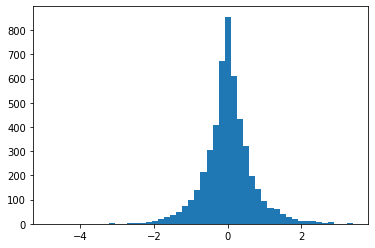

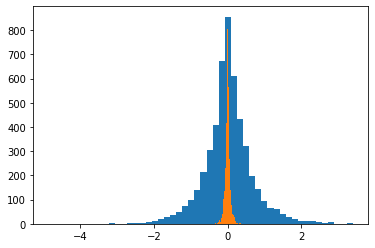

In [34]:
vol_model = time_varying_vol()

Q1 = Hedger(S0, K, T, r, mu, n_sims, n_steps, vol_model = vol_model)
error_Q1, price_Q1 = Q1.simulate_delta_varying_vol()
plt.figure(0)
plt.hist(error_Q1, bins = 50)

High_steps_Q1 = Hedger(S0, K, T, r, mu, n_sims, n_steps * 100, vol_model = vol_model)
error_Q1_high, price_Q1_high2 = High_steps_Q1.simulate_delta_varying_vol()

plt.figure(1)
plt.hist(error_Q1, bins = 50)
plt.hist(error_Q1_high, bins = 50)

In [35]:
print(price_Q1)

3.1573080857906497


In [37]:
assert_almost_equal(np.percentile(error_Q1, q = [2.5, 97.5]), np.array([-1.3886681,  1.4653935]))

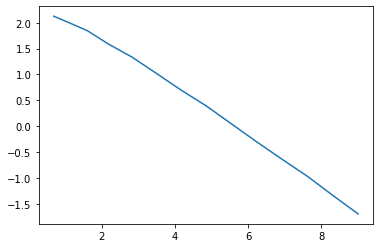

In [ ]:
n_points = 14
n_steps_rme_testing = np.zeros(n_points)
rms_error = np.zeros(n_points)
for i in range(0, n_points):
    n_steps_rme_testing[i] = 2 ** i + 1
    dummy_hedger = Hedger(S0, K, T, r, mu, n_sims, int(n_steps_rme_testing[i]), vol_model = vol_model)
    error, price = dummy_hedger.simulate_delta_varying_vol()
    rms_error[i] = np.sqrt(np.mean(error ** 2))

ax = plt.gca()
ax.plot(np.log(n_steps_rme_testing), np.log(rms_error))

## Q2

In [38]:
Dummy = Hedger(S0, K, T, r, mu, n_sims, n_steps, vol_model = vol_model, simulation_end_time = T/2)

e, p = Dummy.simulate_delta_varying_vol()

(array([  1.,   4.,   9.,  15.,  40.,  74., 157., 270., 437., 652., 858.,
        828., 703., 440., 270., 140.,  66.,  21.,   9.,   6.]),
 array([-0.46086212, -0.41865194, -0.37644176, -0.33423158, -0.29202139,
        -0.24981121, -0.20760103, -0.16539085, -0.12318067, -0.08097049,
        -0.03876031,  0.00344987,  0.04566006,  0.08787024,  0.13008042,
         0.1722906 ,  0.21450078,  0.25671096,  0.29892114,  0.34113133,
         0.38334151]),
 <BarContainer object of 20 artists>)

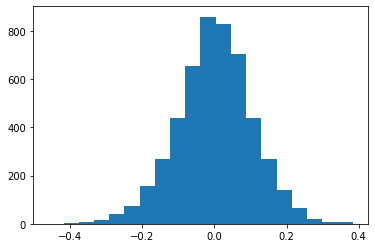

In [39]:
plt.hist(e, bins = 20)

In [40]:
Q2_Test = Hedger(S0, K, 0.3, r, mu, 1_000, 1_000, vol_model = vol_model, simulation_end_time = 0.15, constant_vol_assumption = True)
Q2_test_error, Q2_price_error = Q2_Test.simulate_delta_varying_vol()


(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.,   1.,   2.,   1.,   7.,   7.,
         13., 561., 387.,   8.,   6.,   3.,   0.,   1.]),
 array([-5.32491685e-03, -5.10287204e-03, -4.88082722e-03, -4.65878241e-03,
        -4.43673759e-03, -4.21469277e-03, -3.99264796e-03, -3.77060314e-03,
        -3.54855832e-03, -3.32651351e-03, -3.10446869e-03, -2.88242387e-03,
        -2.66037906e-03, -2.43833424e-03, -2.21628942e-03, -1.99424461e-03,
        -1.77219979e-03, -1.55015498e-03, -1.32811016e-03, -1.10606534e-03,
        -8.84020526e-04, -6.61975710e-04, -4.39930894e-04, -2.17886077e-04,
         4.15873928e-06,  2.26203556e-04,  4.48248372e-04,  6.70293188e-04,
         8.92338005e-04,  1.11438282e-03,  1.33642764e-03]),
 <BarContainer object of 30 artists>)

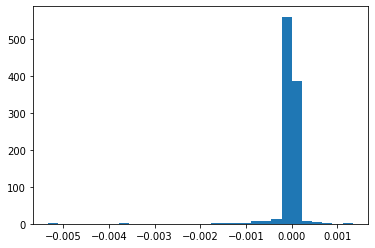

In [41]:
plt.hist(Q2_test_error, bins = 30)

(array([ 1.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  1.,  1.,  3.,  5.,  6.,
         8.,  9.,  8., 10., 19., 11., 27., 14., 20., 26., 28., 21., 20.,
        32., 31., 39., 43., 33., 50., 48., 41., 46., 52., 43., 54., 43.,
        35., 36., 39., 37., 27., 17.,  7.,  6.,  0.,  0.,  1.]),
 array([1.46325753, 1.5290148 , 1.59477207, 1.66052934, 1.72628661,
        1.79204388, 1.85780114, 1.92355841, 1.98931568, 2.05507295,
        2.12083022, 2.18658749, 2.25234476, 2.31810203, 2.3838593 ,
        2.44961656, 2.51537383, 2.5811311 , 2.64688837, 2.71264564,
        2.77840291, 2.84416018, 2.90991745, 2.97567472, 3.04143198,
        3.10718925, 3.17294652, 3.23870379, 3.30446106, 3.37021833,
        3.4359756 , 3.50173287, 3.56749014, 3.6332474 , 3.69900467,
        3.76476194, 3.83051921, 3.89627648, 3.96203375, 4.02779102,
        4.09354829, 4.15930556, 4.22506282, 4.29082009, 4.35657736,
        4.42233463, 4.4880919 , 4.55384917, 4.61960644, 4.68536371,
        4.75112098]),
 <BarContainer

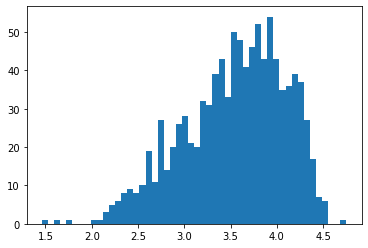

In [42]:
Q2 = Hedger(S0, K, T, r, mu, 1_000, 1_000, vol_model = vol_model, simulation_end_time = T/2, constant_vol_assumption = True)
error_Q2, price_Q2 = Q2.simulate_delta_varying_vol()

plt.hist(error_Q2, bins = 50)

In [44]:
assert_almost_equal(np.percentile(error_Q2, q = [2.5, 97.5]), np.array([2.3824194, 4.3781215]))

(array([ 1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  1.,  0.,  1.,  1.,  2.,  2.,  3.,  4.,  2.,
         5.,  3.,  3.,  6.,  3.,  5.,  5.,  5.,  3., 16.,  6.,  5., 11.,
        16.,  7.,  7., 12.,  8., 16., 10., 16., 12.,  9., 12.,  6., 14.,
        14., 18., 17., 14., 17., 22., 23., 20., 18., 15., 31., 19., 32.,
        16., 23., 18., 19., 27., 26., 26., 26., 17., 26., 28., 23., 20.,
        16., 19., 19., 17., 20., 19., 23., 14., 15., 12., 10.,  7.,  3.,
         4.,  2.,  4.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([1.46325753, 1.49613617, 1.5290148 , 1.56189343, 1.59477207,
        1.6276507 , 1.66052934, 1.69340797, 1.72628661, 1.75916524,
        1.79204388, 1.82492251, 1.85780114, 1.89067978, 1.92355841,
        1.95643705, 1.98931568, 2.02219432, 2.05507295, 2.08795159,
        2.12083022, 2.15370885, 2.18658749, 2.21946612, 2.25234476,
        2.28522339, 2.31810203, 2.35098066, 2.3838593 , 2.41673793,
        2.44961656, 2.4824

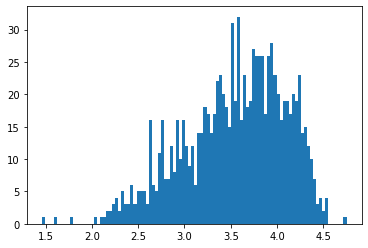

In [45]:
plt.hist(error_Q2, bins = 100)

## Q3 

In [46]:
Q3_vol_model = time_varying_vol()

def flat_vol(t):
    return sigma1 + sigma2

Q3_vol_model.time_varying_vol = flat_vol

assert(Q3_vol_model.time_varying_vol(1) == sigma1 + sigma2)

(array([  6.,   2.,   8.,   7.,   7.,  26.,  39.,  68.,  78., 124., 196.,
        245., 369., 504., 647., 683., 551., 424., 349., 216., 162., 117.,
         67.,  40.,  43.,   8.,  11.,   1.,   1.,   1.]),
 array([-0.02110593, -0.01972409, -0.01834224, -0.0169604 , -0.01557855,
        -0.01419671, -0.01281486, -0.01143302, -0.01005117, -0.00866932,
        -0.00728748, -0.00590563, -0.00452379, -0.00314194, -0.0017601 ,
        -0.00037825,  0.00100359,  0.00238544,  0.00376728,  0.00514913,
         0.00653097,  0.00791282,  0.00929466,  0.01067651,  0.01205835,
         0.0134402 ,  0.01482204,  0.01620389,  0.01758573,  0.01896758,
         0.02034942]),
 <BarContainer object of 30 artists>)

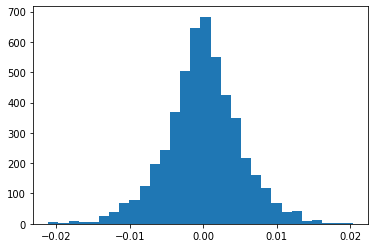

In [47]:
Q3 = Hedger(S0, K, T, r, mu, n_sims, n_steps, vol_model = Q3_vol_model, simulation_end_time = T/2, constant_vol_assumption = True, do_gamma_hedging = True)
error_Q3, price_Q3 = Q3.simulate_delta_varying_vol()
plt.figure(0)
plt.hist(error_Q3, bins = 30)

## Q4

(array([ 8., 23., 34., 60., 72., 79., 70., 76., 71., 74., 63., 50., 53.,
        47., 46., 38., 33., 18., 15., 20., 11., 11.,  8., 12.,  4.,  1.,
         0.,  2.,  0.,  1.]),
 array([-2.43169095e-04, -2.07149444e-04, -1.71129792e-04, -1.35110141e-04,
        -9.90904889e-05, -6.30708372e-05, -2.70511856e-05,  8.96846603e-06,
         4.49881177e-05,  8.10077693e-05,  1.17027421e-04,  1.53047073e-04,
         1.89066724e-04,  2.25086376e-04,  2.61106027e-04,  2.97125679e-04,
         3.33145331e-04,  3.69164982e-04,  4.05184634e-04,  4.41204286e-04,
         4.77223937e-04,  5.13243589e-04,  5.49263241e-04,  5.85282892e-04,
         6.21302544e-04,  6.57322195e-04,  6.93341847e-04,  7.29361499e-04,
         7.65381150e-04,  8.01400802e-04,  8.37420454e-04]),
 <BarContainer object of 30 artists>)

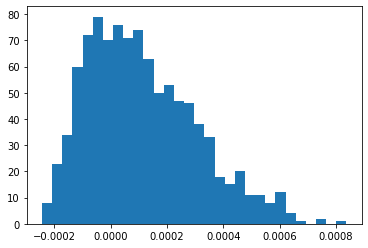

In [48]:
Q4_vol_model = time_varying_vol()
Q4 = Hedger(S0, K, T, r, mu, 1_000, 10_000, vol_model = Q4_vol_model, simulation_end_time = T/2, constant_vol_assumption = True, do_gamma_hedging = True)
error_Q4, price_Q4 = Q4.simulate_delta_varying_vol()

plt.hist(error_Q4, bins = 30)

In [49]:
np.percentile(error_Q4, q = [2.5, 97.5])

array([-0.0001825 ,  0.00055599])

In [ ]:
-0.00017839,  0.0005658